In [34]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [35]:
import torch
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [36]:
!pip install transformers

In [37]:
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/MinorProject/eng_train.csv")
df=df.drop(columns=['ID','Sub-task B'])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(20)

Number of training sentences: 4,263



,Text,Sub-task A
3883,great show,NAG
2439,There just problem with the movie and where I ...,NAG
1786,Rohit barman nice,NAG
2329,Totally agreed with your practicality but ther...,NAG
2567,From today onward she will be called kungfu bitc?,NAG
3534,very good,NAG
1572,<https://youtu.be/ghDIOlPnaA4>,NAG
1393,Very true ! And best analysis covering all thi...,NAG
1830,I want to ask Singer like Sona Mohapatra But t...,CAG
2339,Koyel Di rite and very nice,NAG


In [38]:
df['Sub-task A'] = df['Sub-task A'].map({'CAG': 0, 'NAG':1,'OAG':2})
df.head()

,Text,Sub-task A
0,Next part,1
1,Iii8mllllllm\nMdxfvb8o90lplppi0005,1
2,🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more v...,1
3,What the fuck was this? I respect shwetabh and...,1
4,Concerned authorities should bring arundathi R...,1


In [0]:
df=df.rename(columns={"Sub-task A":"label"})

In [0]:
sentences = df.Text.values
labels = df.label.values

In [41]:
sentences

array(['Next part', 'Iii8mllllllm\nMdxfvb8o90lplppi0005',
       '🤣🤣😂😂🤣🤣🤣😂osm vedio ....keep it up...make more vedios like this',
       ...,
       'People may criticize Pratik Borade by saying that he takes movies too\nseriously and always talks about ideologies instead of focusing on technical\naspects. But ideology IS the most important thing. People in India are\ninfluenced by movies more than anything else. So if a movie is trying to\npromote negativity in society subliminally or openly it needs to be called out\nand criticised openly. Some will say "Oh it is just a film." But many people\nDO take these movies seriously and it does affect as well as change their\nlives. So though I disagree with Pratik regarding some movies, I hugely\nrespect what he does. Filmmakers should not be allowed to create whatever\nbullshit they want to manipulate minds of youths, simply in the name of\nartistic freedom!',
       '@Naaz Sk hello',
       'We want to read your book sir, please make it av

In [42]:
labels

array([1, 1, 1, ..., 0, 1, 1])

In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [44]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent, 
                        add_special_tokens = True,
                   )
    input_ids.append(encoded_sent)

Token indices sequence length is longer than the specified maximum sequence length for this model (676 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (997 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (606 > 512). Running this sequence through the model will result in indexing errors


In [45]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  999


In [0]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 100
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [0]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [0]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.1)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [51]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3, 
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [52]:
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )


In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [57]:
import random
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)            
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:39.
  Batch    80  of    120.    Elapsed: 0:01:19.

  Average training loss: 0.63
  Training epcoh took: 0:01:59

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:39.
  Batch    80  of    120.    Elapsed: 0:01:19.

  Average training loss: 0.43
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:39.
  Batch    80  of    120.    Elapsed: 0:01:18.

  Average training loss: 0.33
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:39.
  Batch    80  of    120.    Elapsed: 0:01:18.

  Average training loss: 0.24
  Training epcoh took: 0:01:57

Ru

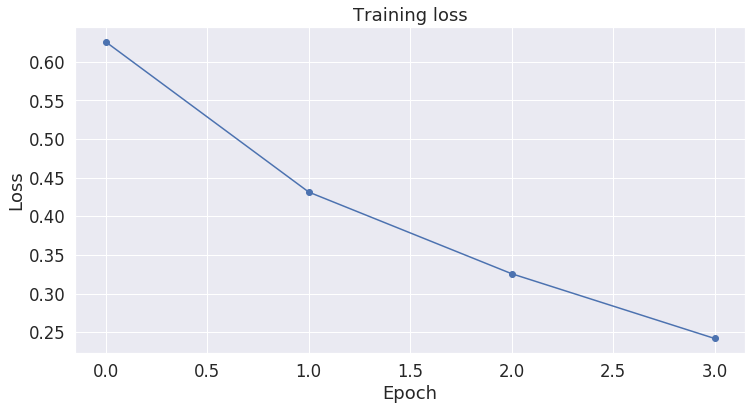

In [58]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(loss_values, 'b-o')
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [59]:
df1 = pd.read_csv("/content/drive/My Drive/MinorProject/eng_dev.csv")
df1=df1.drop(columns=['ID','Sub-task B'])
print('Number of test sentences: {:,}\n'.format(df1.shape[0]))
df1['Sub-task A'] = df1['Sub-task A'].map({'CAG': 0, 'NAG':1,'OAG':2})
df1

Number of test sentences: 1,066



,Text,Sub-task A
0,U deserve more subscribers. U really great.,1
1,Nice video....,1
2,sorry if i bother somebody.. iam a defence asp...,1
3,Joker was amazing....it was not glamorised !.....,1
4,Nice baro,1
...,...,...
1061,Ranu Mandal is third class [woman.No](http://w...,2
1062,[15:23](https://www.youtube.com/watch?v=N_ZMfQ...,1
1063,Love u bro keep it up,1
1064,May I help you?,1


In [0]:
df1=df1.rename(columns={"Sub-task A":"label"})
sentences = df1.Text.values
labels = df1.label.values


In [61]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
                        sent,                     
                        add_special_tokens = True, 
                                           )
    
    input_ids.append(encoded_sent)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
attention_masks = []
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


In [62]:

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
model.eval()
predictions , true_labels = [], []
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits) 
  true_labels.append(label_ids)


Predicting labels for 1,066 test sentences...


In [63]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 4245 of 4263 (99.58%)


In [64]:
from sklearn.metrics import classification_report
clf_set = []
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  clf = classification_report(true_labels[i], pred_labels_i)                
  clf_set.append(clf)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
clf = classification_report(flat_true_labels, flat_predictions)
print(clf)

              precision    recall  f1-score   support

           0       0.31      0.28      0.30       117
           1       0.88      0.91      0.89       836
           2       0.57      0.48      0.52       113

    accuracy                           0.80      1066
   macro avg       0.59      0.56      0.57      1066
weighted avg       0.78      0.80      0.79      1066

